### Import packages

In [217]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import astropy.units as u
from datetime import datetime
import sys, os
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chi2, binned_statistic
pd.set_option('display.max_columns', None)

from astropy.coordinates import SkyCoord

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# location of the scripts
sys.path.insert(0, os.getcwd() + "/../scripts/")
import geometry as geom

# Filter parameters

In [482]:
# Source ------------
source_coordinates = SkyCoord.from_name("crab")
# Select here the desired range of telescope pointings around the source. 
# The values below are for standard wobble observations (0.4 deg source offset)
min_angle_to_source = 0.35 * u.deg
max_angle_to_source = 0.45 * u.deg

# p-value of subrun interpolation scaling -----------
min_pval = 1e-9

# mean intensity power index -----------
min_pindex   = -2.4
max_pindex   = -2.0
max_u_pindex =  0.2

# run lengths ------
min_run_length = 40
max_run_length = 30 * 60

# cosmic rates ------
min_bad_rates            = 0.2
threshold_good_bad_rates = 1.4
max_good_rates           = 2.
max_u_rates              = 0.05

# dates defined as "good" -------
min_date_good = datetime.fromisoformat("2022-11-18")
max_date_good = datetime.fromisoformat("2023-02-14")

# weather thresholds -------
threshold_tng_dust = 2.
threshold_humidity = 60.

### Paths and directories

In [330]:
# Root path of this script
root = os.getcwd() + "/"
# Path to store objects
root_objects = root + f"objects/"

# Some filenames -------------------
# Filename of the total table
fname_runwise_table  = root_objects + "runwise_total_dict.pkl"

# Create the paths that do not exist
for path in [root + "plots/"]:
    if not os.path.exists(path):
        os.makedirs(os.path.join(path), exist_ok=True)

### Reading the run-wise table

In [331]:
# Read DataFrame from CSV
df_runwise = pd.read_csv(fname_runwise_table)
df_runwise.set_index("run", inplace=True)
times_runwise = np.array([datetime.fromisoformat(t) for t in df_runwise["timestamp"]])

total_obs_time = sum(df_runwise["telapsed"]) / 3600
print(f"The total dataset contains {len(df_runwise)} runs, and observation time {total_obs_time:.2f}h")
display(df_runwise[:6])

The total dataset contains 7528 runs, and observation time 2025.22h


,n_subruns,telapsed,timestamp,az,zd,i_half_peak,drdi,u_drdi,pindex,u_pindex,light_yield,u_light_yield,pressure,temperature,humidity,wind_speed,tng_dust,tng_seeing,fit_slope,fit_u_slope,fit_intercept,fit_u_intercept,fit_chi2,fit_pvalue,ra,dec
run,,,,,,,,,,,,,,,,,,,,,,,,,,
1615,61,1479.185384,2019-11-23 23:40:47.731307,265.754848,31.359290,124.759916,2.045992,0.020157,-2.126104,0.059882,1.155216,0.013513,787.011475,7.588689,45.536721,14.341311,0.380000,1.710000,-0.000016,0.000006,1.158636,0.005587,259.529051,0.000000,8.676201,22.059712
1616,62,1492.465697,2019-11-24 00:11:26.987927,95.332874,30.722616,124.538413,2.085128,0.021588,-2.114527,0.062913,1.176689,0.015404,786.889839,7.951452,46.629677,14.384194,0.277419,2.077581,0.000009,0.000004,1.169722,0.003368,69.341068,0.191536,83.659785,21.844168
1617,35,877.161720,2019-11-24 00:45:42.507987,273.215706,44.511343,118.418470,2.049730,0.019581,-2.127638,0.058021,1.157435,0.013404,786.620000,7.710571,51.568000,15.432286,0.260000,2.140000,0.000004,0.000007,1.150611,0.003916,71.571138,0.000114,8.675483,22.076830
1618,81,1822.499924,2019-11-24 01:07:29.246502,108.322078,18.014448,125.807134,2.164965,0.038297,-2.051108,0.094747,1.160424,0.066008,786.379877,7.585802,60.808272,13.873580,0.086790,2.463827,0.000001,0.000004,1.182540,0.003499,252.113457,0.000000,83.668157,21.922445
1619,30,922.360651,2019-11-24 01:45:25.986127,279.314177,57.571760,112.330784,2.045831,0.021450,-2.085522,0.063585,1.161393,0.015284,786.082000,7.658333,58.738667,15.738000,0.030000,2.570000,-0.000030,0.000009,1.174208,0.005152,42.331114,0.040341,8.704526,22.086164
1620,78,1748.229183,2019-11-24 02:03:06.030581,148.833255,8.163757,125.248930,2.099011,0.021409,-2.123014,0.061951,1.182556,0.015357,785.949103,7.733974,57.757564,16.961667,0.030000,2.375385,-0.000024,0.000003,1.199698,0.003803,124.860485,0.000352,83.531399,21.910342


## Creating performance paper dataset

In [332]:
runs_performance_paper = [ 2914, 2929, 2930, 2931, 2932, 2933, 2934, 2949, 2950, 2967, 2968,
                           2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2988, 2989,
                           2990, 2991, 2992, 3004, 3005, 3006, 3007, 3008, 3093, 3094, 3095,
                           3096, 3231, 3232, 3243, 3270, 3271, 3272, 3273, 3274, 3275, 3276,
                           3277, 3278, 3279, 3318, 3319, 3320, 3321, 3328, 3329, 3330, 3338,
                           3339, 3340, 3355, 3356, 3373, 3598, 3599, 3600, 3601, 3615, 3632,
                           3633, 3634, 3635, 3672, 3673, 3674, 3675, 3676, 3677, 3706, 3707,
                           3708, 4067, 4068, 4086, 4087, 6045, 6073, 6304, 6872, 6873, 6874,
                           6875, 6892, 6893, 6894, 6895, 7097, 7098, 7099, 7133, 7136, 7161,
                           7195, 7196, 7197, 7199, 7200, 7227, 7228, 7231, 7232, 7233, 7253,
                           7254, 7255, 7256, 7274, 7275, 7276, 7277]

df_performance = df_runwise.loc[runs_performance_paper]
times_performance = np.array([datetime.fromisoformat(t) for t in df_performance["timestamp"]])

total_obs_time = sum(df_performance["telapsed"]) / 3600
print(f"The performance paper dataset contains {len(df_performance)} runs, and observation time {total_obs_time:.2f}h")

The performance paper dataset contains 117 runs, and observation time 35.87h


# Filtering Crab only observations

In [333]:
telescope_pointing  = SkyCoord(ra=np.array(df_runwise["ra"])*u.deg, dec=np.array(df_runwise["dec"])*u.deg)
angular_distance    = source_coordinates.separation(telescope_pointing)
skyregion_selection = ((angular_distance > min_angle_to_source) & (angular_distance < max_angle_to_source))

df_crab = df_runwise[skyregion_selection]
times_crab = np.array([datetime.fromisoformat(t) for t in df_crab["timestamp"]])

total_obs_time = sum(df_crab["telapsed"]) / 3600
print(f"\nThe crab dataset contains {len(df_crab)} runs, and observation time {total_obs_time:.2f}h")
print(f" - {len(df_crab)/len(df_runwise)*100:.1f}% of the runs\n")


The crab dataset contains 1241 runs, and observation time 334.61h
 - 16.5% of the runs



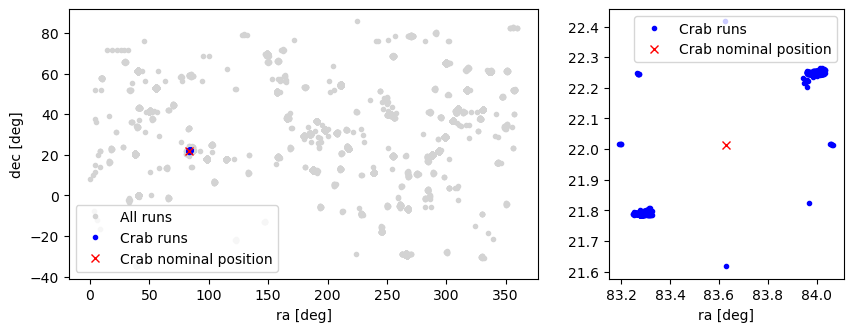

In [334]:
fig, (ax, axz) = plt.subplots(1, 2, figsize=(10, 3.5), gridspec_kw={'width_ratios': [2, 1]})


ax.plot(df_runwise["ra"], df_runwise["dec"], marker=".", ls="", color="lightgray", label="All runs")
ax.plot(df_crab["ra"], df_crab["dec"], marker=".", ls="", color="b", label="Crab runs")

axz.plot(df_crab["ra"], df_crab["dec"], marker=".", ls="", color="b", label="Crab runs")

for axe in [ax, axz]:
    axe.plot(source_coordinates.ra.deg, source_coordinates.dec.deg, marker="x", ls="", color="r", label="Crab nominal position")
    axe.set_xlabel("ra [deg]")
    axe.legend()
ax.set_ylabel("dec [deg]")

# plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

# Filtering by p-value

In [335]:
df_pvalue_filtered = df_crab.query(f"fit_pvalue > {min_pval}")

total_obs_time = sum(df_pvalue_filtered["telapsed"]) / 3600
print(f"\nThe p-value filtered (p-value > {min_pval:.1e}):")
print(f"Dataset contains {len(df_pvalue)} runs, and observation time {total_obs_time:.2f}h")
print(f" - {len(df_pvalue_filtered)/len(df_crab)*100:.1f}% of the runs\n")


The p-value filtered (p-value > 1.0e-09):
Dataset contains 506 runs, and observation time 112.88h
 - 40.8% of the runs



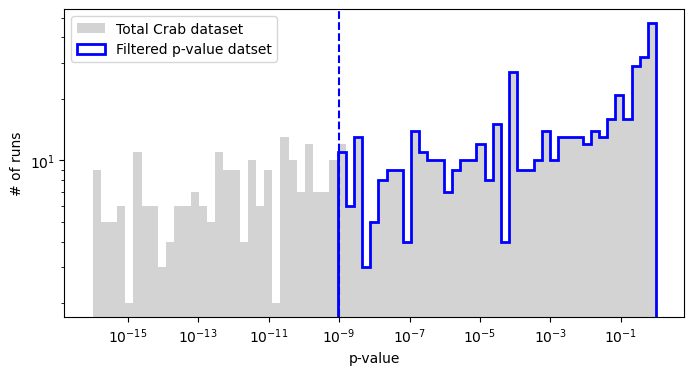

In [374]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.hist(df_crab["fit_pvalue"], np.logspace(-16, 0, 70), color="lightgray", label="Total Crab dataset")
ax.hist(df_pvalue_filtered["fit_pvalue"], np.logspace(-16, 0, 70), color="b", histtype="step", lw=2, label="Filtered p-value datset")

ax.axvline(min_pval, color="b", ls="--")

ax.loglog()
ax.legend()
ax.set_xlabel("p-value")
ax.set_ylabel("# of runs")

# plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

# Filtering by slope

In [337]:
df_slope_filtered = df_pvalue_filtered.query(f"pindex < {max_pindex} & pindex > {min_pindex} & u_pindex < {max_u_pindex}")

total_obs_time = sum(df_slope_filtered["telapsed"]) / 3600
print(f"\nThe slope filtered ({min_pindex:.2f} < slope < {max_pindex:.2f}):")
print(f"Dataset contains {len(df_slope_filtered)} runs, and observation time {total_obs_time:.2f}h")
print(f" - {len(df_slope_filtered)/len(df_pvalue_filtered)*100:.1f}% of the runs\n")


The slope filtered (-2.40 < slope < -2.00):
Dataset contains 444 runs, and observation time 97.81h
 - 87.7% of the runs



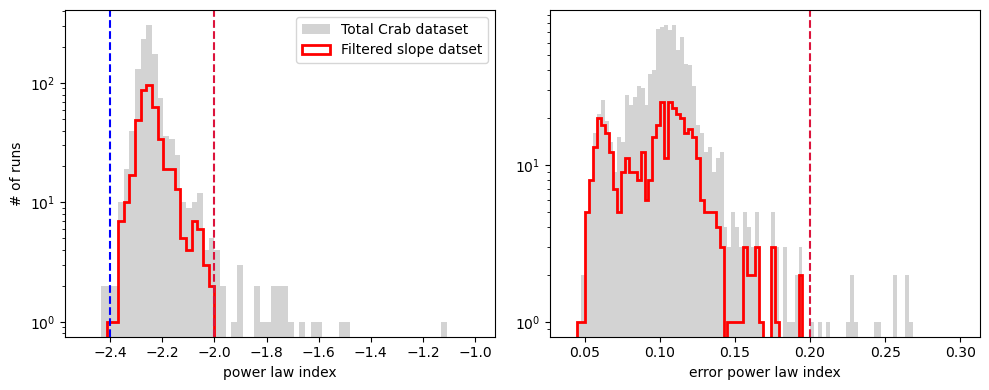

In [376]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.hist(df_crab["pindex"], np.linspace(-2.5, -1, 70), color="lightgray", label="Total Crab dataset")
# ax1.hist(df_pvalue_filtered["pindex"], np.linspace(-2.5, -1, 70), color="b", histtype="step", lw=2, label="Filtered p-value datset")
ax1.hist(df_slope_filtered["pindex"], np.linspace(-2.5, -1, 70), color="r", histtype="step", lw=2, ls="-", label="Filtered slope datset")

ax2.hist(df_crab["u_pindex"], np.linspace(0.04, 0.3, 100), color="lightgray")
# ax2.hist(df_pvalue_filtered["u_pindex"], np.linspace(0.04, 0.3, 100), color="b", histtype="step", lw=2, label="Filtered p-value datset")
ax2.hist(df_slope_filtered["u_pindex"], np.linspace(0.04, 0.3, 100), color="r", histtype="step", lw=2, ls="-", label="Filtered slope datset")

ax1.axvline(min_pindex, color="b", ls="--")
ax1.axvline(max_pindex, color="crimson", ls="--")
ax2.axvline(max_u_pindex, color="crimson", ls="--")

ax1.set_xlabel("power law index")
ax2.set_xlabel("error power law index")
ax1.set_ylabel("# of runs")
for ax in [ax1, ax2]:
    ax.set_yscale("log")
ax1.legend()
fig.tight_layout()

# plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

# Filtering by run longitude

In [377]:
df_runlong_filtered = df_slope_filtered.query(f"telapsed < {max_run_length} & telapsed > {min_run_length}")

total_obs_time = sum(df_runlong_filtered["telapsed"]) / 3600
print(f"\nThe run lenght filtered ({min_run_length:.0f}s < length < {max_run_length/60:.1f}min):")
print(f"Dataset contains {len(df_runlong_filtered)} runs, and observation time {total_obs_time:.2f}h")
print(f" - {len(df_runlong_filtered)/len(df_slope_filtered)*100:.1f}% of the runs\n")


The run lenght filtered (40s < length < 30.0min):
Dataset contains 439 runs, and observation time 97.77h
 - 98.9% of the runs



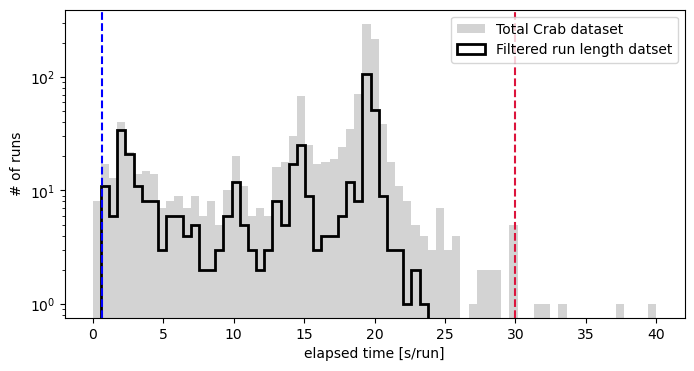

In [411]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.hist(df_crab["telapsed"]/60, np.linspace(0, 40, 70), color="lightgray", label="Total Crab dataset")
ax.hist(df_runlong_filtered["telapsed"]/60, np.linspace(0, 40, 70), color="k", histtype="step", lw=2, label="Filtered run length datset")

ax.axvline(min_run_length/60, color="b", ls="--")
ax.axvline(max_run_length/60, color="crimson", ls="--")

ax.set_yscale("log")
ax.legend()
ax.set_xlabel("elapsed time [s/run]")
ax.set_ylabel("# of runs")

# plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

# Filtering good and bad rates runs

In [407]:
df_goodrates_filtered = df_runlong_filtered.query(f"drdi > {threshold_good_bad_rates} & drdi < {max_good_rates} & u_drdi < {max_u_rates}")
df_badrates_filtered  = df_runlong_filtered.query(f"drdi < {threshold_good_bad_rates} & drdi > {min_bad_rates} & u_drdi < {max_u_rates}")

print(f"\nThe \"good\" rate runs ({threshold_good_bad_rates:.2f} < rates @ 422 p.e. < {max_good_rates:.2f}):")
total_obs_time = sum(df_goodrates_filtered["telapsed"]) / 3600
print(f"Dataset contains {len(df_goodrates_filtered)} runs, and observation time {total_obs_time:.2f}h")
print(f" - {len(df_goodrates_filtered)/len(df_runlong_filtered)*100:.1f}% of the runs\n")

print(f"\nThe \"bad\" rate runs ({min_bad_rates:.2f} < rates @ 422 p.e. < {threshold_good_bad_rates:.2f}):")
total_obs_time = sum(df_badrates_filtered["telapsed"]) / 3600
print(f"Dataset contains {len(df_badrates_filtered)} runs, and observation time {total_obs_time:.2f}h")
print(f" - {len(df_badrates_filtered)/len(df_runlong_filtered)*100:.1f}% of the runs\n")


The "good" rate runs (1.40 < rates @ 422 p.e. < 2.00):
Dataset contains 356 runs, and observation time 78.46h
 - 81.1% of the runs


The "bad" rate runs (0.20 < rates @ 422 p.e. < 1.40):
Dataset contains 81 runs, and observation time 19.06h
 - 18.5% of the runs



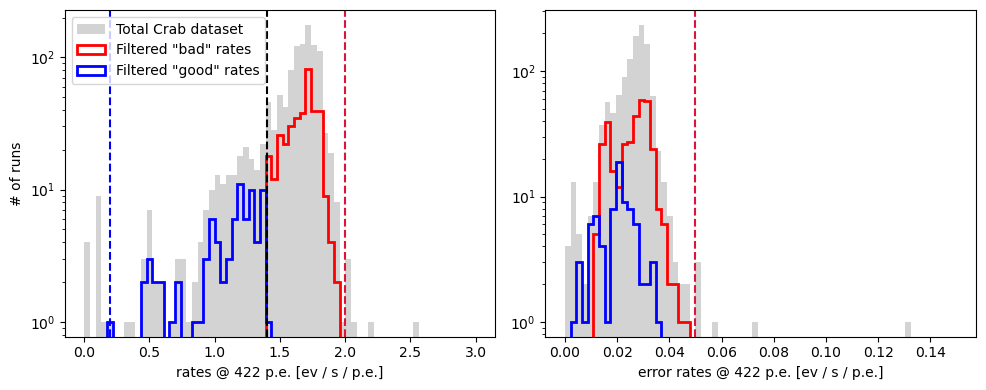

In [410]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.hist(df_crab["drdi"], np.linspace(0, 3, 70), color="lightgray", label="Total Crab dataset")
ax1.hist(df_goodrates_filtered["drdi"], np.linspace(0, 3, 70), color="r", histtype="step", lw=2, ls="-", label="Filtered \"bad\" rates")
ax1.hist(df_badrates_filtered["drdi"], np.linspace(0, 3, 70), color="b", histtype="step", lw=2, ls="-", label="Filtered \"good\" rates")

ax2.hist(df_crab["u_drdi"], np.linspace(0, 0.15, 70), color="lightgray", label="Total Crab dataset")
ax2.hist(df_goodrates_filtered["u_drdi"], np.linspace(0, 0.15, 70), color="r", histtype="step", lw=2, ls="-", label="Filtered \"bad\" rates")
ax2.hist(df_badrates_filtered["u_drdi"], np.linspace(0, 0.15, 70), color="b", histtype="step", lw=2, ls="-", label="Filtered \"good\" rates")

ax1.axvline(min_bad_rates, color="b", ls="--")
ax1.axvline(threshold_good_bad_rates, color="k", ls="--")
ax1.axvline(max_good_rates, color="crimson", ls="--")
ax2.axvline(max_u_rates, color="crimson", ls="--")

ax1.set_xlabel("rates @ 422 p.e. [ev / s / p.e.]")
ax2.set_xlabel("error rates @ 422 p.e. [ev / s / p.e.]")
ax1.set_ylabel("# of runs")
for ax in [ax1, ax2]:
    ax.set_yscale("log")
ax1.legend()
fig.tight_layout()

# plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

# Good period runs

In [448]:
times_goodrates_filtered = np.array([datetime.fromisoformat(t) for t in df_goodrates_filtered["timestamp"]])
mask_good_period = ((times_goodrates_filtered > min_date_good) & (times_goodrates_filtered < max_date_good))

df_good_period   = df_goodrates_filtered[mask_good_period]
times_goodperiod = np.array([datetime.fromisoformat(t) for t in df_good_period["timestamp"]])

total_obs_time = sum(df_good_period["telapsed"]) / 3600
print("\nThe run lenght filtered ({} < date < {}):".format(str(min_date_good).split(" ")[0], str(max_date_good).split(" ")[0]))
print(f"Dataset contains {len(df_good_period)} runs, and observation time {total_obs_time:.2f}h")
print(f" - {len(df_good_period)/len(df_goodrates_filtered)*100:.1f}% of the runs\n")


The run lenght filtered (2022-11-18 < date < 2023-02-14):
Dataset contains 143 runs, and observation time 23.84h
 - 40.2% of the runs



# Other good runs

In [452]:
df_good_others = df_goodrates_filtered[~mask_good_period]
df_good_others = df_good_others.query(f"run not in @runs_performance_paper")
times_good_others = np.array([datetime.fromisoformat(t) for t in df_good_others["timestamp"]])

print(f"\nThe other \"good\" rate runs:")
total_obs_time = sum(df_good_others["telapsed"]) / 3600
print(f"Dataset contains {len(df_good_others)} runs, and observation time {total_obs_time:.2f}h")
print(f" - {len(df_good_others)/len(df_goodrates_filtered)*100:.1f}% of the runs\n")


The other "good" rate runs:
Dataset contains 183 runs, and observation time 45.75h
 - 51.4% of the runs



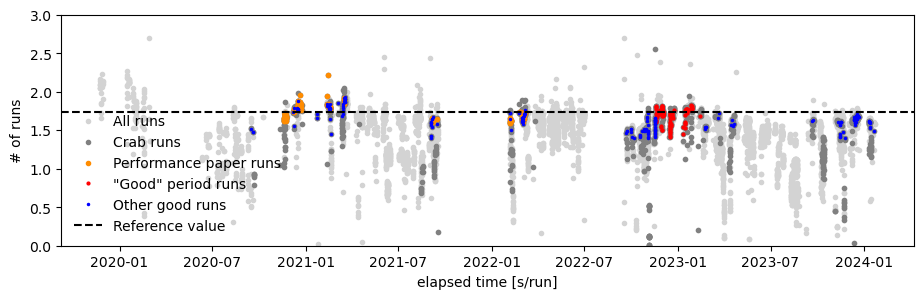

In [519]:
fig, ax = plt.subplots(1, 1, figsize=(11, 3))

ax.plot(times_runwise, df_runwise["drdi"], ls="", marker=".", color="lightgray", label="All runs")
ax.plot(times_crab, df_crab["drdi"], ls="", marker=".", color="gray", label="Crab runs")
ax.plot(times_performance, df_performance["drdi"], ls="", marker=".", color="darkorange", label="Performance paper runs")

ax.plot(times_goodperiod, df_good_period["drdi"], ls="", marker=".", color="r", ms=4, label="\"Good\" period runs")
ax.plot(times_good_others, df_good_others["drdi"], ls="", marker=".", color="b", ms=3, label="Other good runs")

ax.axhline(ref_p0, color="k", ls="--", label="Reference value")

ax.legend(loc=3, frameon=False)
ax.set_xlabel("elapsed time [s/run]")
ax.set_ylabel("# of runs")
ax.set_ylim(0, 3)

# plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

# Weather masking for the bad runs

In [506]:
df_good_weather = df_badrates_filtered.query(f"tng_dust < {threshold_tng_dust} & humidity < {threshold_humidity}")
df_bad_weather  = df_badrates_filtered.query(f"tng_dust > {threshold_tng_dust} | humidity > {threshold_humidity}")
times_good_weather = np.array([datetime.fromisoformat(t) for t in df_good_weather["timestamp"]])
times_bad_weather  = np.array([datetime.fromisoformat(t) for t in df_bad_weather["timestamp"]])

print(f"\nThe \"bad\" rates runs with good weather (tng_dust < {threshold_tng_dust:.1f}ug/m3 & humidity < {threshold_humidity}%):")
total_obs_time = sum(df_good_weather["telapsed"]) / 3600
print(f"Dataset contains {len(df_good_weather)} runs, and observation time {total_obs_time:.2f}h")
print(f" - {len(df_good_weather)/len(df_badrates_filtered)*100:.1f}% of the runs\n")

print(f"\nThe \"bad\" rates runs with bad weather (tng_dust > {threshold_tng_dust:.1f}ug/m3 & humidity > {threshold_humidity}%):")
total_obs_time = sum(df_bad_weather["telapsed"]) / 3600
print(f"Dataset contains {len(df_bad_weather)} runs, and observation time {total_obs_time:.2f}h")
print(f" - {len(df_bad_weather)/len(df_badrates_filtered)*100:.1f}% of the runs\n")


The "bad" rates runs with good weather (tng_dust < 2.0ug/m3 & humidity < 60.0%):
Dataset contains 8 runs, and observation time 1.39h
 - 9.9% of the runs


The "bad" rates runs with bad weather (tng_dust > 2.0ug/m3 & humidity > 60.0%):
Dataset contains 31 runs, and observation time 6.66h
 - 38.3% of the runs



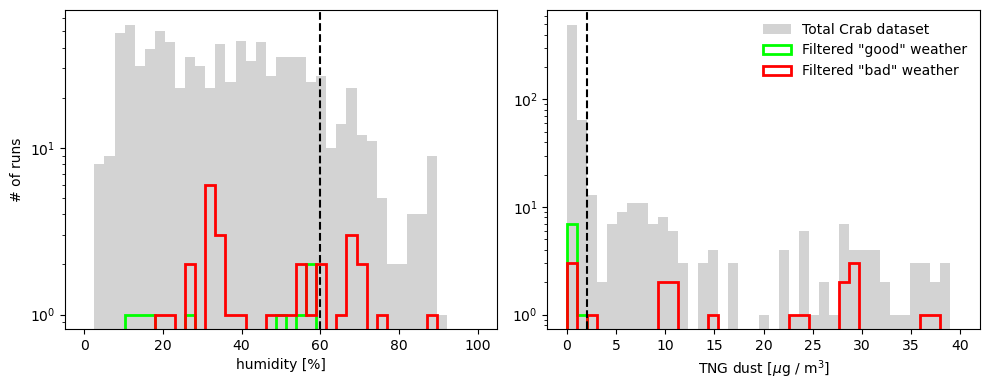

In [520]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.hist(df_crab["humidity"], np.linspace(0, 100, 40), color="lightgray", label="Total Crab dataset")
ax1.hist(df_good_weather["humidity"], np.linspace(0, 100, 40), color="lime", histtype="step", lw=2, ls="-", label="Filtered \"good\" weather")
ax1.hist(df_bad_weather["humidity"], np.linspace(0, 100, 40), color="r", histtype="step", lw=2, ls="-", label="Filtered \"bad\" weather")

ax2.hist(df_crab["tng_dust"], np.linspace(0, 40, 40), color="lightgray", label="Total Crab dataset")
ax2.hist(df_good_weather["tng_dust"], np.linspace(0, 40, 40), color="lime", histtype="step", lw=2, ls="-", label="Filtered \"good\" weather")
ax2.hist(df_bad_weather["tng_dust"], np.linspace(0, 40, 40), color="r", histtype="step", lw=2, ls="-", label="Filtered \"bad\" weather")

ax1.axvline(threshold_humidity, color="k", ls="--")
ax2.axvline(threshold_tng_dust, color="k", ls="--")

ax1.set_xlabel("humidity [%]")
ax2.set_xlabel("TNG dust [$\mu$g / m$^3$]")
ax1.set_ylabel("# of runs")
for ax in [ax1, ax2]:
    ax.set_yscale("log")
ax2.legend(frameon=False)
fig.tight_layout()

# plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

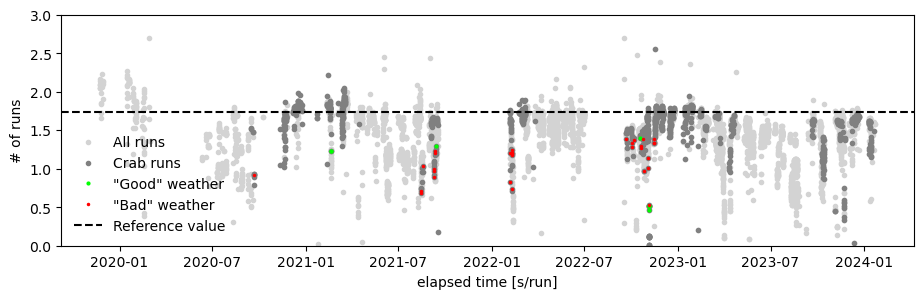

In [509]:
fig, ax = plt.subplots(1, 1, figsize=(11, 3))

ax.plot(times_runwise, df_runwise["drdi"], ls="", marker=".", color="lightgray", label="All runs")
ax.plot(times_crab, df_crab["drdi"], ls="", marker=".", color="gray", label="Crab runs")

ax.plot(times_good_weather, df_good_weather["drdi"], ls="", marker=".", color="lime", ms=4, label="\"Good\" weather")
ax.plot(times_bad_weather, df_bad_weather["drdi"], ls="", marker=".", color="r", ms=3, label="\"Bad\" weather")

ax.axhline(ref_p0, color="k", ls="--", label="Reference value")

ax.legend(loc=3, frameon=False)
ax.set_xlabel("elapsed time [s/run]")
ax.set_ylabel("# of runs")
ax.set_ylim(0, 3)

# plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

In [518]:
print(f"\nPerformance paper runs: ({len(df_performance)})\n")
display(np.array(df_performance.index))

print(f"\n\n\"Good\" period runs: ({len(df_good_period)})\n")
display(np.array(df_good_period.index))

print(f"\n\nOther \"good\" runs: ({len(df_good_others)})\n")
display(np.array(df_good_others.index))

print(f"\n\n\"Bad\" rates good weather runs: ({len(df_good_weather)})\n")
display(np.array(df_good_weather.index))

print(f"\n\n\"Bad\" rates bad weather runs: ({len(df_bad_weather)})\n")
display(np.array(df_bad_weather.index))


Performance paper runs: (117)



array([2914, 2929, 2930, 2931, 2932, 2933, 2934, 2949, 2950, 2967, 2968,
       2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2988, 2989,
       2990, 2991, 2992, 3004, 3005, 3006, 3007, 3008, 3093, 3094, 3095,
       3096, 3231, 3232, 3243, 3270, 3271, 3272, 3273, 3274, 3275, 3276,
       3277, 3278, 3279, 3318, 3319, 3320, 3321, 3328, 3329, 3330, 3338,
       3339, 3340, 3355, 3356, 3373, 3598, 3599, 3600, 3601, 3615, 3632,
       3633, 3634, 3635, 3672, 3673, 3674, 3675, 3676, 3677, 3706, 3707,
       3708, 4067, 4068, 4086, 4087, 6045, 6073, 6304, 6872, 6873, 6874,
       6875, 6892, 6893, 6894, 6895, 7097, 7098, 7099, 7133, 7136, 7161,
       7195, 7196, 7197, 7199, 7200, 7227, 7228, 7231, 7232, 7233, 7253,
       7254, 7255, 7256, 7274, 7275, 7276, 7277])



"Good" period runs: (143)



array([10665, 10667, 10668, 10671, 10672, 10673, 10674, 10860, 10863,
       10880, 10883, 10916, 10917, 10919, 10950, 10988, 10989, 11014,
       11017, 11019, 11088, 11124, 11125, 11164, 11166, 11167, 11179,
       11186, 11188, 11189, 11191, 11192, 11193, 11194, 11196, 11197,
       11198, 11208, 11209, 11219, 11220, 11221, 11222, 11223, 11224,
       11225, 11228, 11229, 11230, 11231, 11237, 11238, 11239, 11240,
       11241, 11243, 11244, 11245, 11246, 11247, 11249, 11250, 11251,
       11252, 11253, 11254, 11256, 11257, 11258, 11259, 11260, 11261,
       11262, 11263, 11264, 11265, 11266, 11267, 11268, 11269, 11270,
       11271, 11272, 11273, 11276, 11277, 11278, 11280, 11282, 11354,
       11355, 11357, 11358, 11359, 11360, 11361, 11362, 11363, 11376,
       11377, 11378, 11379, 11380, 11381, 11382, 11383, 11384, 11408,
       11409, 11410, 11429, 11439, 11466, 11470, 11472, 11488, 11492,
       11512, 11562, 11576, 11609, 11610, 11630, 11634, 11649, 11650,
       11651, 11652,



Other "good" runs: (183)



array([ 2691,  2758,  2759,  3088,  3098,  3100,  3236,  3237,  3245,
        3265,  3267,  3268,  3269,  3514,  3516,  3584,  3586,  3631,
        3636,  3637,  3638,  3639,  3650,  3655,  3679,  3680,  3683,
        3684,  3705,  3712,  3725,  3894,  3961,  4009,  4010,  4011,
        4015,  4033,  4073,  4075,  4129,  4146,  4147,  4148,  4149,
        5955,  5957,  5958,  5992,  5993,  5994,  5995,  6011,  6042,
        6044,  6072,  6282,  6871,  6887,  6891,  6935,  7084,  7087,
        7088,  7134,  7140,  7141,  7142,  7143,  7169,  7170,  7172,
        7173,  7174,  7201,  7234,  7236,  7278,  7282,  7304,  9252,
        9274,  9278,  9434,  9436,  9437,  9519,  9596,  9687,  9688,
        9689,  9824,  9905,  9907,  9929,  9996,  9998, 10030, 10034,
       10035, 10083, 10084, 10085, 10086, 10089, 10090, 10206, 10215,
       10590, 10591, 10592, 10593, 10594, 10595, 10596, 10597, 10599,
       10600, 10601, 10602, 10603, 10604, 10630, 10632, 10633, 10634,
       10635, 10636,



"Bad" rates good weather runs: (8)



array([ 3729,  3730,  6242,  9686, 10258, 10260, 10262, 10263])



"Bad" rates bad weather runs: (31)



array([ 2767,  5738,  5758,  5800,  6166,  6168,  6169,  6192,  6194,
        6852,  6853,  6962,  6963,  6964,  6965,  6966,  6990,  9253,
        9513,  9514,  9595,  9715,  9716,  9849,  9882, 10077, 10078,
       10264, 10526, 10527, 10528])